In [2]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Boettcher_TP53"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [3]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [4]:
scoreset

,Unnamed: 0,POS,Wt_codon,Wt_aa,Vt_aa,R1_Nutlin_GFP_high,R1_Nutlin_GFP_low,R1_DMSO_GFP_high,R1_DMSO_GFP_low,R3_Nutlin_GFP_high,R3_Nutlin_GFP_low,R3_DMSO_GFP_high,R3_DMSO_GFP_low,pDNAPool_PCR,pUC57-p53Clonal_straight,group,R1_Nutlin_Ratio_Lo_Hi,R3_Nutlin_Ratio_Lo_Hi,R1_DMSO_Ratio_Lo_Hi,R3_DMSO_Ratio_Lo_Hi,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,author_transcript,hgvs_pro,score,synonymous,nonsense
0,1,2,GAG,E,N,0.002163,0.002726,0.002788,0.002508,0.002449,0.002279,0.002827,0.001957,0.003390,0.000000,Intended_VT,0.100504,-0.031149,-0.045897,-0.159793,NaN,NaN,NaN,0.131653,0.113896,NaN,p.Glu2Asn,0.034678,False,False
1,2,2,GAG,E,K,0.001408,0.001317,0.001543,0.001076,0.001365,0.001464,0.001317,0.001706,0.001262,0.000025,Intended_VT,-0.028912,0.030377,-0.156697,0.112438,NaN,NaN,NaN,NaN,NaN,NaN,p.Glu2Lys,0.000733,False,False
2,3,2,GAG,E,T,0.001125,0.000847,0.001012,0.000842,0.000931,0.001098,0.000992,0.000727,0.001334,0.000000,Intended_VT,-0.123009,0.071713,-0.079905,-0.135260,NaN,NaN,NaN,NaN,NaN,NaN,p.Glu2Thr,-0.025648,False,False
3,4,2,GAG,E,S,0.000714,0.000905,0.000902,0.001035,0.000743,0.000880,0.000893,0.000975,0.001124,0.000000,Intended_VT,0.102814,0.073928,0.059944,0.038489,NaN,NaN,NaN,NaN,NaN,NaN,p.Glu2Ser,0.088371,False,False
4,5,2,GAG,E,I,0.001009,0.001301,0.001087,0.000938,0.000786,0.000943,0.000916,0.000468,0.001192,0.000000,Intended_VT,0.110494,0.078855,-0.064186,-0.291672,NaN,NaN,NaN,NaN,NaN,NaN,p.Glu2Ile,0.094674,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7442,7870,393,GAC,D,V,0.000135,0.000078,0.000165,0.000052,0.000143,0.000066,0.000138,0.000116,0.000179,0.000000,Intended_VT,-0.237826,-0.334245,-0.499130,-0.073448,NaN,NaN,NaN,NaN,NaN,NaN,p.Asp393Val,-0.286036,False,False
7443,7871,393,GAC,D,Y,0.000153,0.000165,0.000235,0.000327,0.000268,0.000142,0.000460,0.000179,0.000558,0.000000,Intended_VT,0.032115,-0.274187,0.143179,-0.409503,NaN,NaN,NaN,NaN,NaN,NaN,p.Asp393Tyr,-0.121036,False,False
7444,7873,393,GAC,D,W,0.000069,0.000054,0.000114,0.000045,0.000080,0.000112,0.000147,0.000193,0.000161,0.000000,Intended_VT,-0.109980,0.146388,-0.402910,0.119189,NaN,NaN,NaN,NaN,NaN,NaN,p.Asp393Trp,0.018204,False,False
7445,7874,393,GAC,D,C,0.000089,0.000044,0.000198,0.000047,0.000155,0.000015,0.000123,0.000033,0.000179,0.000000,Intended_VT,-0.310890,-1.010345,-0.626567,-0.569321,NaN,NaN,NaN,NaN,NaN,NaN,p.Asp393Cys,-0.660617,False,False


In [5]:
if scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [6]:
AUTHOR_TRANSCRIPT

'NM_000546'

# Add ClinVar annotations

In [7]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

100%|██████████| 1612/1612 [00:00<00:00, 2227.86it/s]


In [8]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

# Add gnomAD annotations

In [9]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [10]:
Ensembl_transcript_stable_ids

array(['ENST00000269305'], dtype=object)

In [11]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [12]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [13]:
scoreset_processed

,hgvs_pro,Unnamed: 0,POS,Wt_codon,Wt_aa,Vt_aa,R1_Nutlin_GFP_high,R1_Nutlin_GFP_low,R1_DMSO_GFP_high,R1_DMSO_GFP_low,R3_Nutlin_GFP_high,R3_Nutlin_GFP_low,R3_DMSO_GFP_high,R3_DMSO_GFP_low,pDNAPool_PCR,pUC57-p53Clonal_straight,group,R1_Nutlin_Ratio_Lo_Hi,R3_Nutlin_Ratio_Lo_Hi,R1_DMSO_Ratio_Lo_Hi,R3_DMSO_Ratio_Lo_Hi,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,author_transcript,score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Glu2Asn,1,2,GAG,E,N,0.002163,0.002726,0.002788,0.002508,0.002449,0.002279,0.002827,0.001957,0.003390,0.000000,Intended_VT,0.100504,-0.031149,-0.045897,-0.159793,NaN,NaN,NaN,0.131653,0.113896,NaN,0.034678,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Glu2Lys,2,2,GAG,E,K,0.001408,0.001317,0.001543,0.001076,0.001365,0.001464,0.001317,0.001706,0.001262,0.000025,Intended_VT,-0.028912,0.030377,-0.156697,0.112438,NaN,NaN,NaN,NaN,NaN,NaN,0.000733,False,False,0.0,0.0,1.0,0.0,NM_000546.6(TP53):c.4G>A (p.Glu2Lys),1.0,0.03,1.315270e-05,0.03,17:7676591:C:T|17:7676591:C:T|17:7676591:C:T|1...
2,p.Glu2Thr,3,2,GAG,E,T,0.001125,0.000847,0.001012,0.000842,0.000931,0.001098,0.000992,0.000727,0.001334,0.000000,Intended_VT,-0.123009,0.071713,-0.079905,-0.135260,NaN,NaN,NaN,NaN,NaN,NaN,-0.025648,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p.Glu2Ser,4,2,GAG,E,S,0.000714,0.000905,0.000902,0.001035,0.000743,0.000880,0.000893,0.000975,0.001124,0.000000,Intended_VT,0.102814,0.073928,0.059944,0.038489,NaN,NaN,NaN,NaN,NaN,NaN,0.088371,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p.Glu2Ile,5,2,GAG,E,I,0.001009,0.001301,0.001087,0.000938,0.000786,0.000943,0.000916,0.000468,0.001192,0.000000,Intended_VT,0.110494,0.078855,-0.064186,-0.291672,NaN,NaN,NaN,NaN,NaN,NaN,0.094674,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7442,p.Asp393Val,7870,393,GAC,D,V,0.000135,0.000078,0.000165,0.000052,0.000143,0.000066,0.000138,0.000116,0.000179,0.000000,Intended_VT,-0.237826,-0.334245,-0.499130,-0.073448,NaN,NaN,NaN,NaN,NaN,NaN,-0.286036,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.368700e-06,0.00,17:7669613:T:A|17:7669613:T:A
7443,p.Asp393Tyr,7871,393,GAC,D,Y,0.000153,0.000165,0.000235,0.000327,0.000268,0.000142,0.000460,0.000179,0.000558,0.000000,Intended_VT,0.032115,-0.274187,0.143179,-0.409503,NaN,NaN,NaN,NaN,NaN,NaN,-0.121036,False,False,0.0,1.0,0.0,0.0,NM_000546.6(TP53):c.1177G>T (p.Asp393Tyr),1.0,0.00,6.842890e-07,0.00,17:7669614:C:A|17:7669614:C:A
7444,p.Asp393Trp,7873,393,GAC,D,W,0.000069,0.000054,0.000114,0.000045,0.000080,0.000112,0.000147,0.000193,0.000161,0.000000,Intended_VT,-0.109980,0.146388,-0.402910,0.119189,NaN,NaN,NaN,NaN,NaN,NaN,0.018204,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7445,p.Asp393Cys,7874,393,GAC,D,C,0.000089,0.000044,0.000198,0.000047,0.000155,0.000015,0.000123,0.000033,0.000179,0.000000,Intended_VT,-0.310890,-1.010345,-0.626567,-0.569321,NaN,NaN,NaN,NaN,NaN,NaN,-0.660617,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [3]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [4]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [5]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

INVERT_SCORES = True
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)

In [6]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 170
B/LB: 98
gnomAD: 476


(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>], dtype=object))

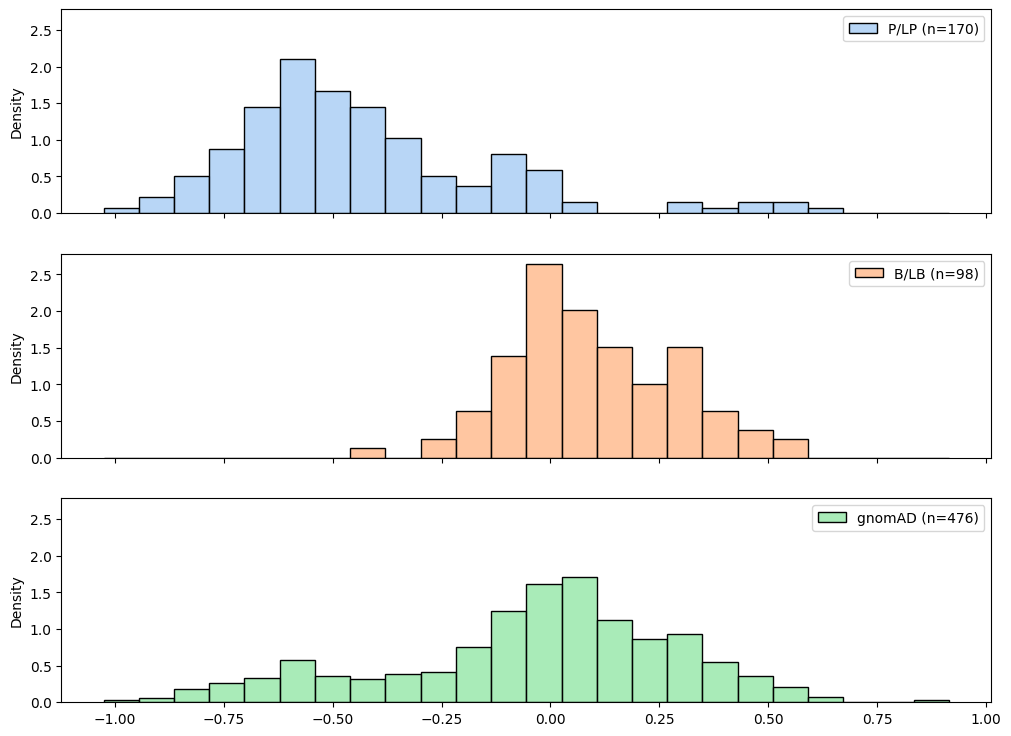

In [7]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [9]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)